In [361]:
from ezc3d import c3d
import numpy as np
import collections, copy, os, itertools, random
# from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt



In [202]:
train_dir = r"C:\Users\anna\Documents\gitHub\NTU\InterpolationModel\data\c3d\train"
test_dir = r"C:\Users\anna\Documents\gitHub\NTU\InterpolationModel\data\c3d\test"

# file = r"C:\Users\Administrator\Documents\gitHub\NTU\InterpolationModel\data\SN268\SN268_0023_10m_01.c3d"




In [331]:
class standardise:
    def __init__(self): 
        self.mapping_anatomical_group_to_marker = {
            'head':[
            'RHEAD',
            'RTEMP',
            'LHEAD',
            'LTEMP'],

            'shoulder':[
            'RACR',
            'LACR'],

            'torso':[
            'STER',
            'XPRO',
            'C7',
            'T4',
            'T8',
            'T10'],
            

            'pelvis':[
            'LPSIS',
            'RPSIS',
            'RASIS',
            'LASIS',
            'LICR',
            'RICR'],

            'arms':[    
            'RHME',
            'RHLE',
            'RUA1',
            'RUA2',
            'RUA3',
            'RUA4',
            'LHME',
            'LHLE',
            'LUA1',
            'LUA2',
            'LUA3',
            'LUA4'],

            'wrist':[
            'LFA1',
            'LFA2',
            'LFA3',
            'LRSP',
            'LUSP',
            'RRSP',
            'RUSP',
            'RFA3',
            'RFA2',
            'RFA1'],

            'hand':[
            'LCAP',
            'LHMC1',
            'LHMC2',
            'LHMC3',
            'RCAP',
            'RHMC1',
            'RHMC2',
            'RHMC3'],

            'fingers':[
            'LTHUMB',
            'RTHUMB',
            'RMIDDLE',
            'LMIDDLE'],

            'thigh':[
            'LFLE',
            'LFME',
            'LTH1',
            'LTH2',
            'LTH3',
            'LTH4',
            'RFLE',
            'RFME',
            'RTH1',
            'RTH2',
            'RTH3',
            'RTH4'],

            'calves':[
            'LSK1',
            'LSK2',
            'LSK3',
            'LSK4',
            'LFAL',
            'LTAM',
            'RSK1',
            'RSK2',
            'RSK3',
            'RSK4',
            'RFAL',
            'RTAM'],

            'foot':[
            'RFCC',
            'RFMT5',
            'RFMT2',
            'RFMT1',
            'LFCC',
            'LFMT5',
            'LFMT2',
            'LFMT1']
            }
        # all tasks
        self.all_tasks = [ 
            "key_stand",
            "back", 
            "mouth", 
            "head", 
            "grasp", 
            "lateral", 
            "towel", 
            "step_down", 
            "step_up", 
            "kerb", 
            "balance", 
            "tug", 
            "10m", 
            "static", 
            "balance_static"]

        # different task needs different markerset; map accordingly by colour
        self.mapping_task_to_color = {
            'towel':'blue', 
            'grasp':'green', 
            'lateral':'green', 
            'mouth':'green', 
            'head':'green', 
            'back':'green', 
            'tug':'pink', 
            'key_stand':'pink', 
            'balance':'yellow', 
            'kerb':'yellow', 
            'step':'yellow', 
            '10m':'yellow',
            'step_down':'yellow',
            'step_up':'yellow',
            'balance_static':'yellow'}
        
        # Experimentation 1: travelling sales man (top down)
        self.mapping_color_to_anatomical_group = {
            'blue':['head', 'shoulder', 'torso', 'pelvis', 'arms', 'wrist', 'hand'],
            'green':['head', 'shoulder', 'torso', 'pelvis', 'arms', 'wrist', 'hand', 'fingers'],
            'pink':['head', 'shoulder', 'torso', 'pelvis', 'arms', 'wrist', 'hand', 'thigh', 'calves', 'foot'],
            'yellow':['head', 'shoulder', 'torso', 'pelvis', 'arms', 'wrist', 'thigh', 'calves', 'foot']
            }
        

    def transform_data(self, file, task):
        '''load file and rearrange the markers that are highly correlated together'''
        # load c3d file
        c = c3d(file)

        # get all markers name in the file and their coordinates
        name_of_markers = c["parameters"]["POINT"]["DESCRIPTIONS"]["value"]
        coordinates_of_markers = c["data"]["points"][0:3,:,:]

        # map task to color to anatomical group to marker in the anatomical group
        anatomical_group = self.mapping_color_to_anatomical_group[self.mapping_task_to_color[task]]
        transformed_data =  None
        transformed_marker_sequence = []
        for group in anatomical_group:
            for marker in self.mapping_anatomical_group_to_marker[group]:
                idx =  name_of_markers.index(marker)

                # start forming the sequence according to self.mapping_color_to_anatomical_group
                if transformed_data is None:
                    transformed_data = coordinates_of_markers[:,idx:idx+1,:]
                else:
                    transformed_data = np.concatenate((transformed_data, coordinates_of_markers[:,idx:idx+1,:]), axis = 1)
                
                transformed_marker_sequence.append(marker)
        print(transformed_data.shape)

        ## to find missing markers
        # check_one_axis = transformed_data[0,:,:]
        # missing_marker_idx = set(np.argwhere(np.isnan(check_one_axis))[:,0])
        # missing_markers_info  = collections.defaultdict()
        # for idx in missing_marker_idx:
        #     # Find the indices where the first dimension changes
        #     indices = np.where(np.argwhere(np.isnan(check_one_axis))[1:, 0] != np.argwhere(np.isnan(check_one_axis))[:-1, 0])[0] + 1
        #     split_arrays = np.split(np.argwhere(np.isnan(check_one_axis)), indices)

        return transformed_data, transformed_marker_sequence

        

In [227]:
def minmax_znorm(data, znorm = True, minmax = True):
    '''minmax after z-score normalisation (standardisation) of the data'''
    manipulate_data = copy.copy(data)
    axes = ['x', 'y', 'z']

    # for inversion of znorm later
    znorm_scaling = collections.defaultdict()
    # for inversion of minmax later
    minmax_scaling = collections.defaultdict()

    for i, axis in enumerate(axes):
        data_in_each_axis = manipulate_data[i:i+1,:,:]
        if znorm == True:
            # record down the standardisation factors for z-score normalisation 
            znorm_scaling["avg_" + axis] = np.mean(data_in_each_axis)
            znorm_scaling["sd_" + axis] = np.std(data_in_each_axis)
            # z-score normalise the data
            manipulate_data[i:i+1,:,:] = ((data_in_each_axis - znorm_scaling["avg_" + axis]) / znorm_scaling["sd_" + axis])
        

        if minmax == True:
            # record down the scaling factors for minmax
            minmax_scaling["min_" + axis] = np.min(data_in_each_axis)
            minmax_scaling["max_" + axis] = np.max(data_in_each_axis)
            # minmax the normalised data
            manipulate_data[i:i+1,:,:] = ((data_in_each_axis - minmax_scaling["min_" + axis]) / (minmax_scaling["max_" + axis] - minmax_scaling["min_" + axis]))

    return znorm_scaling, minmax_scaling, manipulate_data
    # code for minmax scaler if wanted for Experimentation 2: Per-Axis Scaling - preserves the individual characteristics of each time series within an axis.
        # znorm_data_in_each_axis = znorm_data[i,:,:]
        # scaler = MinMaxScaler(feature_range=(0, 1))
        # minmax_znorm_data = scaler.fit_transform(znorm_data_in_each_axis)
        #     minmax_znorm_data = np.dstack((minmax_znorm_data, scaler.fit_transform(znorm_data_in_each_axis)))

In [375]:
minmax_scaling

defaultdict(None,
            {'min_x': -1848.5469970703125,
             'max_x': 2817.251220703125,
             'min_y': -113.6025619506836,
             'max_y': 547.9298095703125,
             'min_z': 6.161131858825684,
             'max_z': 1509.3555908203125})

In [377]:
def inv_minmax_znorm(data, scaling, axis, minmax = False, znorm = False):
    '''done for inv_minmax, not yet for znorm'''
    if minmax == True:
        inv_data = data*(scaling['max_' + axis] - scaling['min_' + axis]) + scaling['min_' + axis]
    return inv_data


In [352]:
def train_test_split(train_data, test_data, marker_to_test, sequence_of_markers, timeframes_to_test):
    '''choose which marker to be tested and at which timeframe'''
    # look for the index of the marker to be tested
    number_of_markers  = test_data.shape[0]/3
    marker_to_test_idx_x = int(sequence_of_markers.index(marker_to_test))
    marker_to_test_idx_y = int(marker_to_test_idx_x + number_of_markers)
    marker_to_test_idx_z = int(marker_to_test_idx_y + number_of_markers)

    # randomized the starting time frame of test data, need to ensure the chosen number will not exceed total timeframe after taking into account the timeframes to test
    start_time = random.randint(0,test_data.shape[1] - 1 -  timeframes_to_test)
    end_time = start_time + timeframes_to_test

    X_train = np.concatenate((train_data[0:marker_to_test_idx_x,:], 
                              train_data[marker_to_test_idx_x + 1:marker_to_test_idx_y,:], 
                              train_data[marker_to_test_idx_y + 1:marker_to_test_idx_z,:],
                              train_data[marker_to_test_idx_z + 1:,:]), axis = 0).T
    y_train = np.concatenate((train_data[marker_to_test_idx_x:marker_to_test_idx_x + 1], 
                              train_data[marker_to_test_idx_y:marker_to_test_idx_y + 1],
                              train_data[marker_to_test_idx_z:marker_to_test_idx_z + 1]), axis = 0)

    X_test = np.concatenate((test_data[0:marker_to_test_idx_x, start_time:end_time], 
                              test_data[marker_to_test_idx_x + 1:marker_to_test_idx_y, start_time:end_time], 
                              test_data[marker_to_test_idx_y + 1:marker_to_test_idx_z, start_time:end_time],
                              test_data[marker_to_test_idx_z + 1:, start_time:end_time]), axis = 0).T
    y_test = np.concatenate((test_data[marker_to_test_idx_x:marker_to_test_idx_x + 1, start_time:end_time], 
                              test_data[marker_to_test_idx_y:marker_to_test_idx_y + 1, start_time:end_time],
                              test_data[marker_to_test_idx_z:marker_to_test_idx_z + 1, start_time:end_time]), axis = 0)

    return X_train, X_test, y_train,  y_test


    

In [228]:
# function that will be used to capture frames of the missing markers
def ranges(i):
    '''function to record continuous numbering'''
    for a, b in itertools.groupby(enumerate(i), lambda pair: pair[1] - pair[0]):
        b = list(b)
        yield b[0][1], b[-1][1]

In [376]:
standardise_data = standardise()
train_data = None
for file in os.listdir(train_dir):
    temp_data, sequence_of_markers = standardise_data.transform_data(os.path.join(train_dir,file), '10m')
    _, _, scaled_data = minmax_znorm(temp_data, minmax = True, znorm = False)
    if train_data is None:
        train_data = scaled_data
    else:
        train_data = np.concatenate((train_data, scaled_data), axis = 2)
train_data = np.vstack(train_data)

test_data = None
for file in os.listdir(test_dir):
    temp_data, sequence_of_markers = standardise_data.transform_data(os.path.join(test_dir,file), '10m')
    znorm_scaling, minmax_scaling, scaled_data = minmax_znorm(temp_data, minmax = True, znorm = False)
    if test_data is None:
        test_data = scaled_data
    else:
        test_data = np.concatenate((test_data, scaled_data), axis = 2)
test_data = np.vstack(test_data)

(3, 72, 423)
(3, 72, 425)
(3, 72, 406)
(3, 72, 431)


In [392]:
test_timeframe_range = 100
frames_interval = 10 
missing_timeframes_to_be_tested = [i for i in range(frames_interval, test_timeframe_range + 1, frames_interval)]

============== X_AXIS ==============
------- TESTING FOR 10 FRAMES -------
Root Mean Squared Error (RMSE): 5.15
Mean Absolute Error (MAE): 4.99
R-squared (R2): 0.97


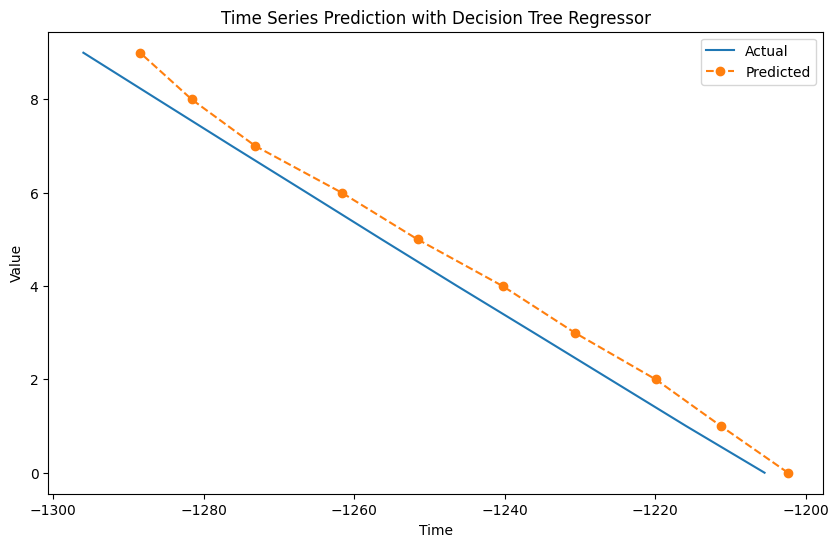

------- TESTING FOR 20 FRAMES -------
Root Mean Squared Error (RMSE): 7.67
Mean Absolute Error (MAE): 6.77
R-squared (R2): 0.98


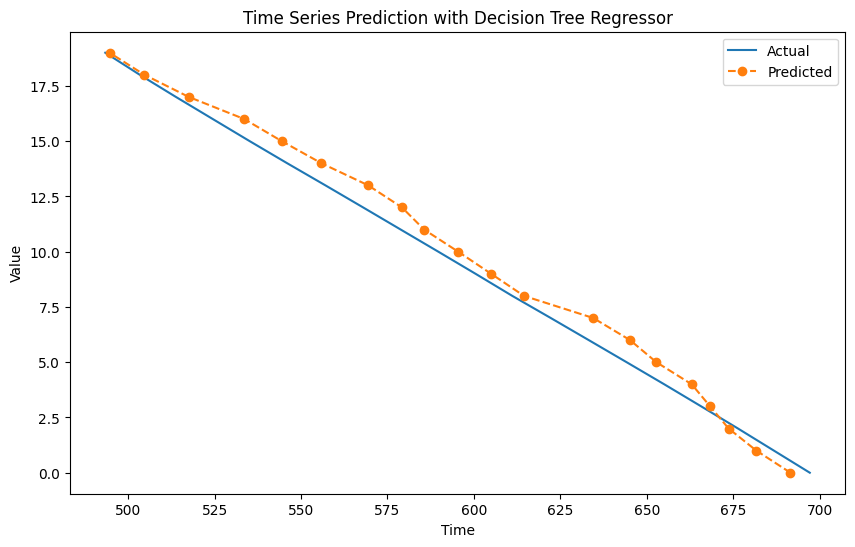

------- TESTING FOR 30 FRAMES -------
Root Mean Squared Error (RMSE): 29.96
Mean Absolute Error (MAE): 24.98
R-squared (R2): 0.88


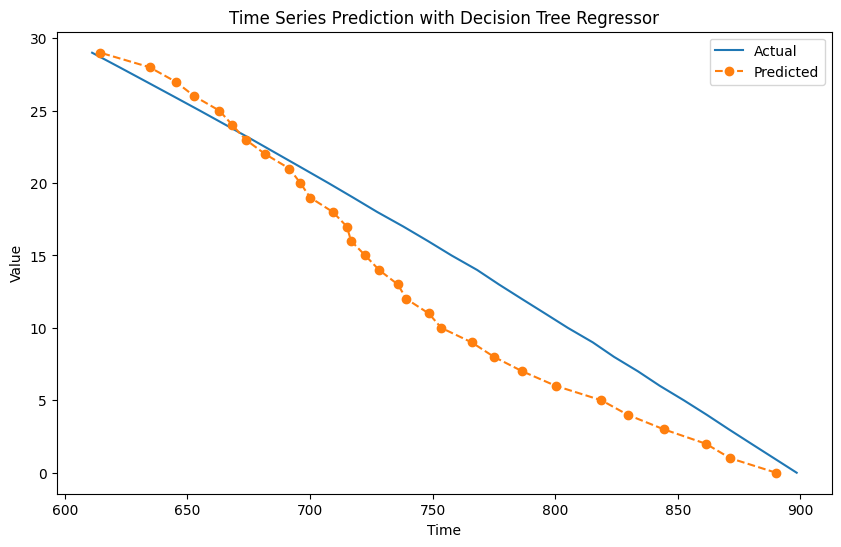

------- TESTING FOR 40 FRAMES -------
Root Mean Squared Error (RMSE): 10.45
Mean Absolute Error (MAE): 9.23
R-squared (R2): 0.99


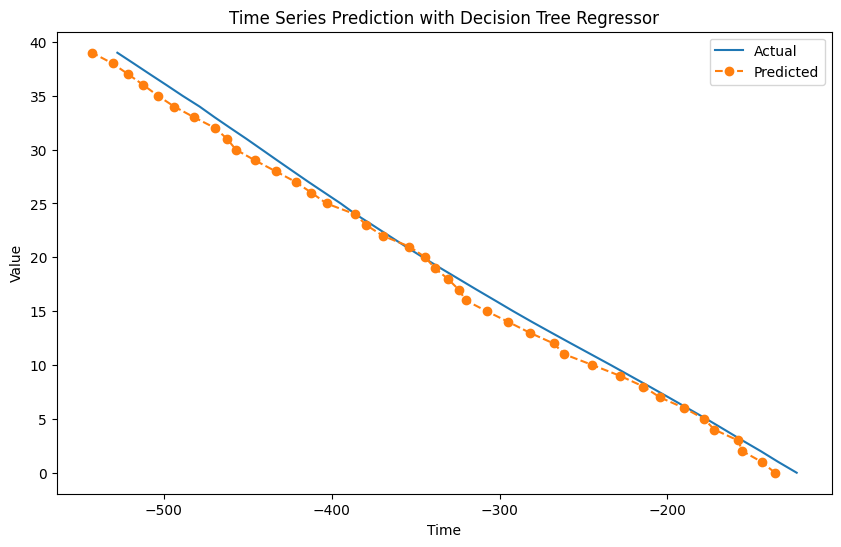

------- TESTING FOR 50 FRAMES -------
Root Mean Squared Error (RMSE): 10.41
Mean Absolute Error (MAE): 7.20
R-squared (R2): 1.00


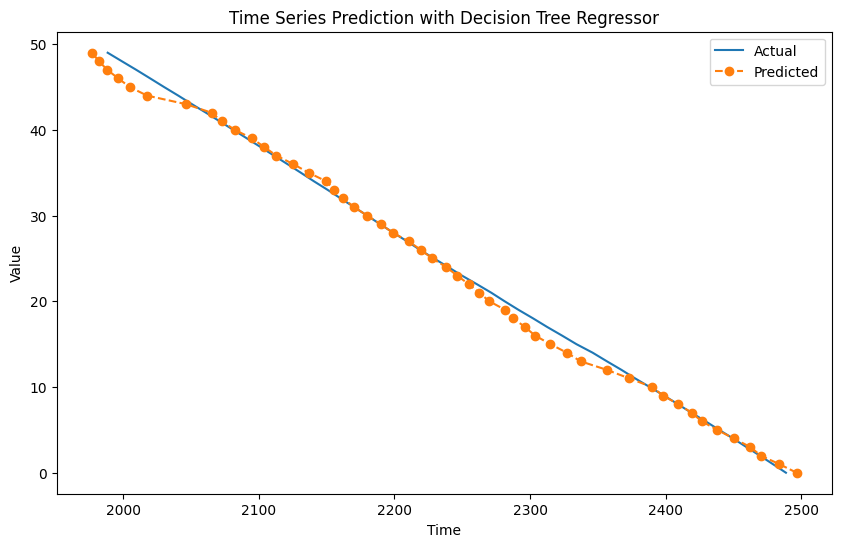

------- TESTING FOR 60 FRAMES -------
Root Mean Squared Error (RMSE): 15.78
Mean Absolute Error (MAE): 10.47
R-squared (R2): 0.99


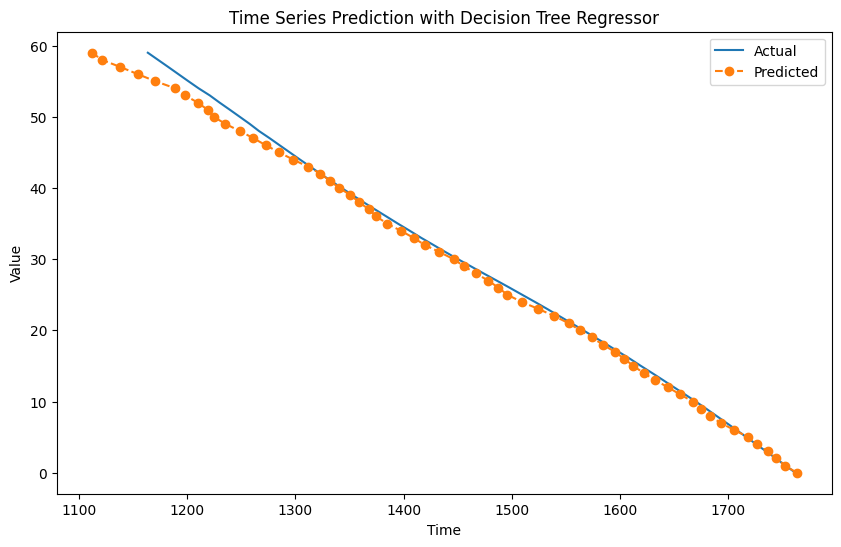

------- TESTING FOR 70 FRAMES -------
Root Mean Squared Error (RMSE): 8.93
Mean Absolute Error (MAE): 7.17
R-squared (R2): 1.00


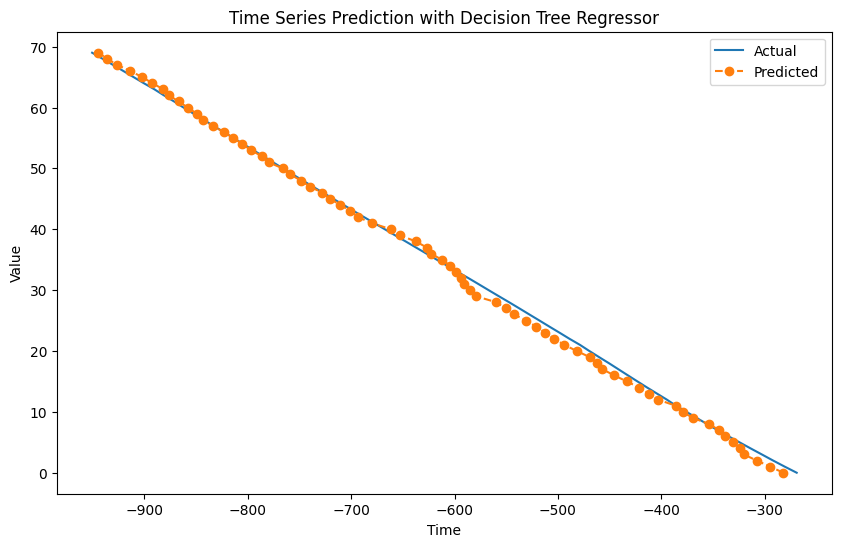

------- TESTING FOR 80 FRAMES -------
Root Mean Squared Error (RMSE): 18.07
Mean Absolute Error (MAE): 11.47
R-squared (R2): 0.99


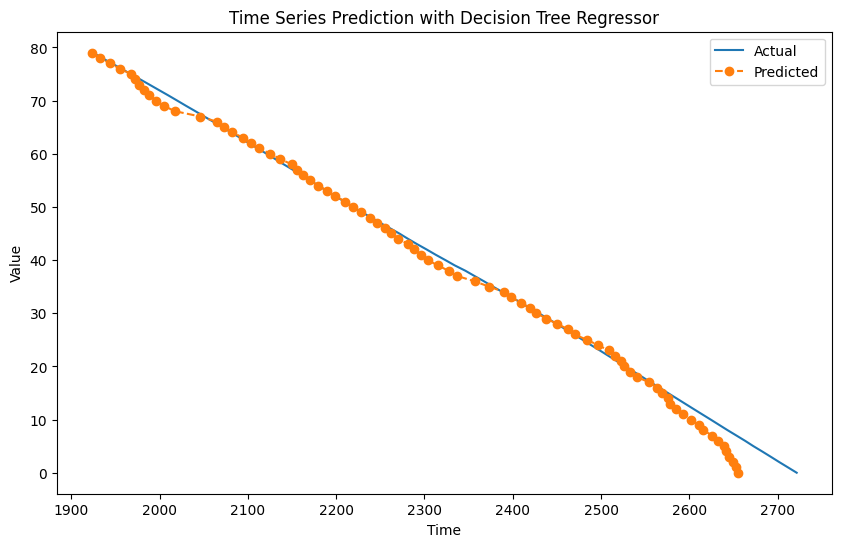

------- TESTING FOR 90 FRAMES -------
Root Mean Squared Error (RMSE): 8.24
Mean Absolute Error (MAE): 6.84
R-squared (R2): 1.00


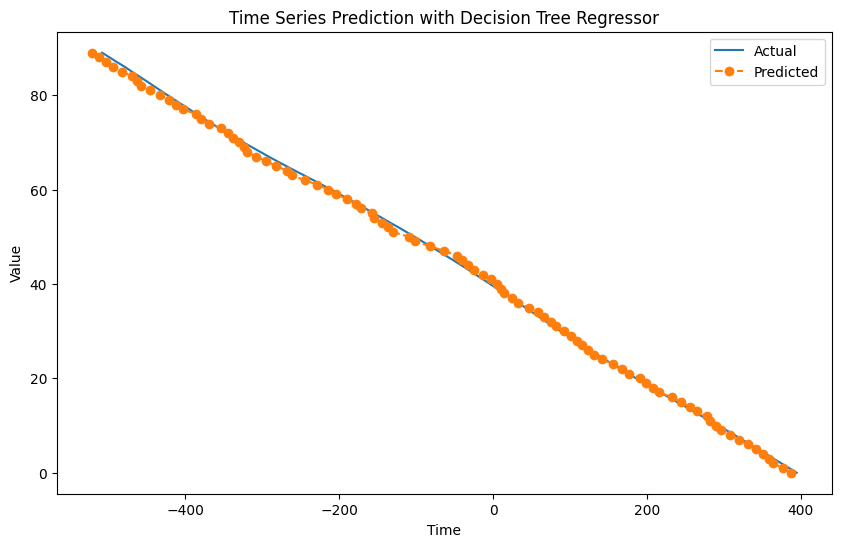

------- TESTING FOR 100 FRAMES -------
Root Mean Squared Error (RMSE): 20.11
Mean Absolute Error (MAE): 11.30
R-squared (R2): 1.00


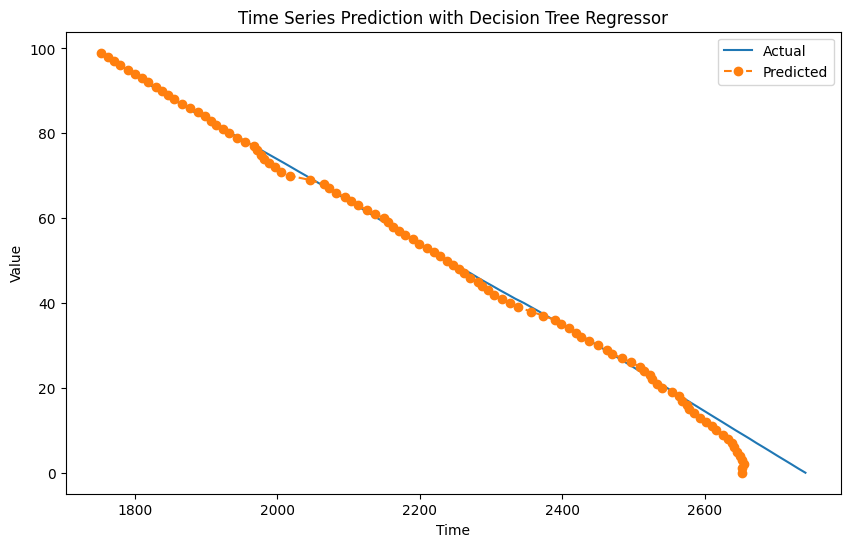

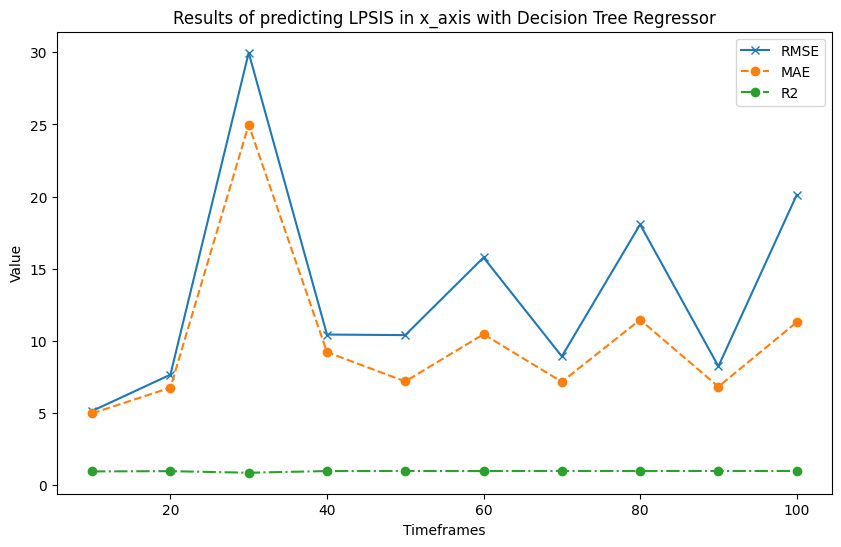

============== Y_AXIS ==============
------- TESTING FOR 10 FRAMES -------
Root Mean Squared Error (RMSE): 26.22
Mean Absolute Error (MAE): 22.25
R-squared (R2): -0.01


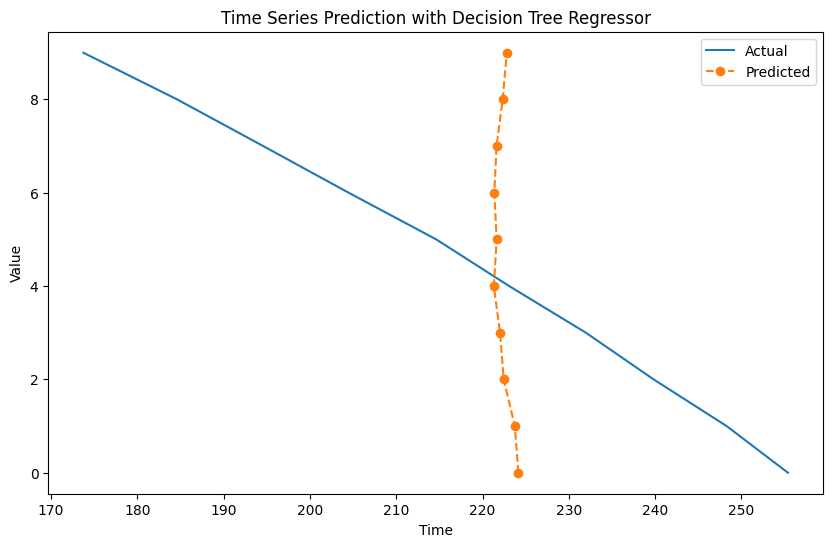

------- TESTING FOR 20 FRAMES -------
Root Mean Squared Error (RMSE): 100.50
Mean Absolute Error (MAE): 97.12
R-squared (R2): -1.69


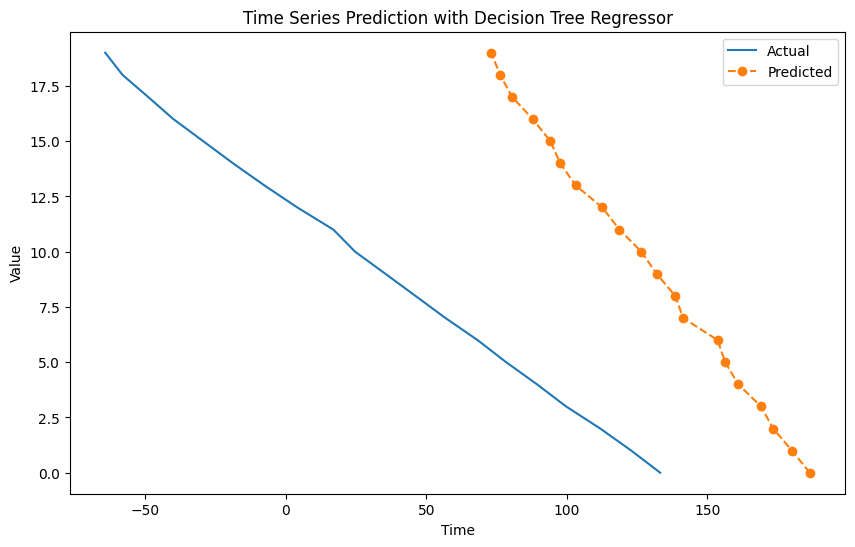

------- TESTING FOR 30 FRAMES -------
Root Mean Squared Error (RMSE): 58.30
Mean Absolute Error (MAE): 53.85
R-squared (R2): 0.33


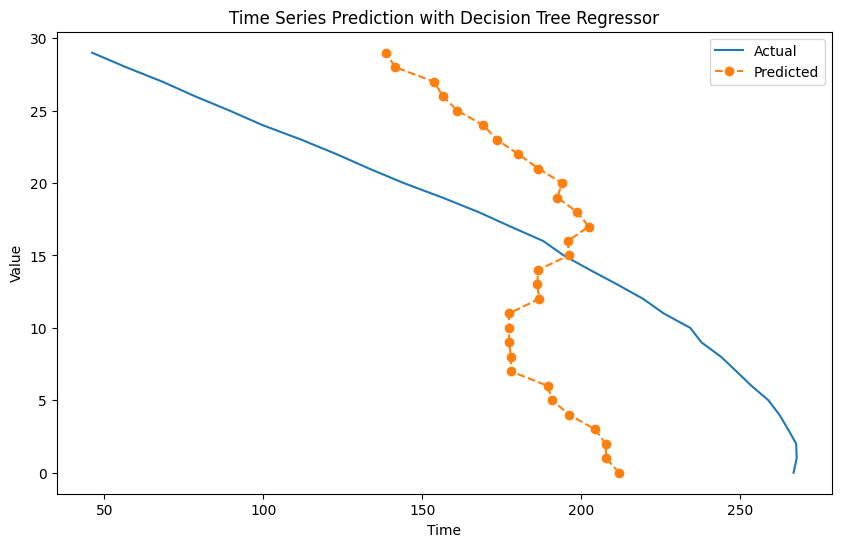

------- TESTING FOR 40 FRAMES -------
Root Mean Squared Error (RMSE): 102.93
Mean Absolute Error (MAE): 61.97
R-squared (R2): -13.16


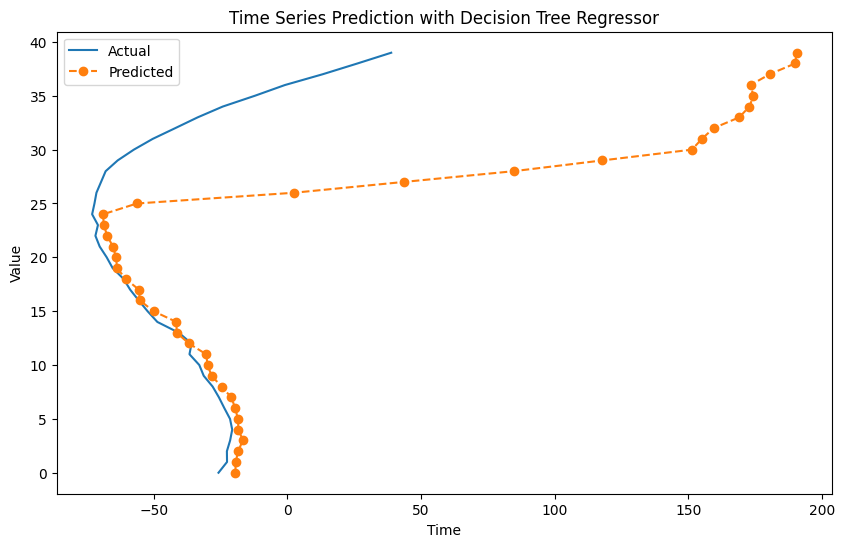

------- TESTING FOR 50 FRAMES -------
Root Mean Squared Error (RMSE): 33.96
Mean Absolute Error (MAE): 28.14
R-squared (R2): 0.85


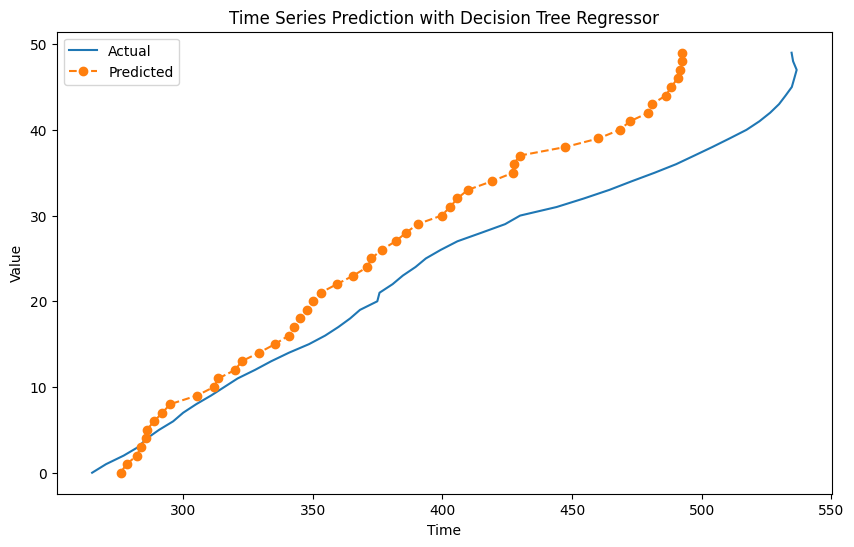

------- TESTING FOR 60 FRAMES -------
Root Mean Squared Error (RMSE): 35.49
Mean Absolute Error (MAE): 31.52
R-squared (R2): 0.61


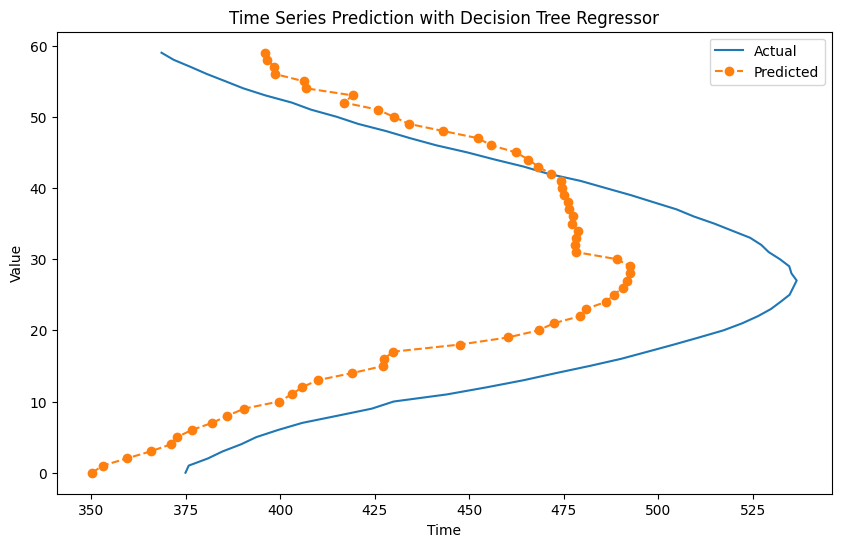

------- TESTING FOR 70 FRAMES -------
Root Mean Squared Error (RMSE): 29.19
Mean Absolute Error (MAE): 11.89
R-squared (R2): -0.05


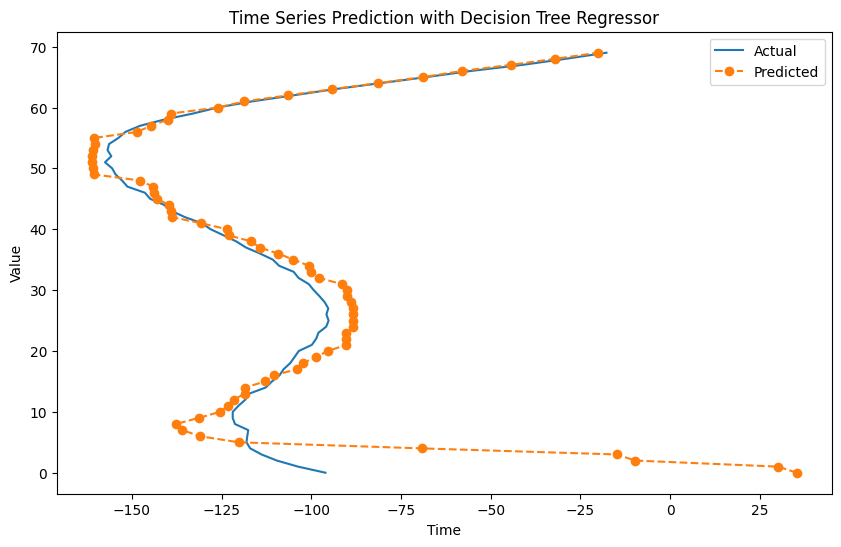

------- TESTING FOR 80 FRAMES -------
Root Mean Squared Error (RMSE): 84.76
Mean Absolute Error (MAE): 71.69
R-squared (R2): 0.56


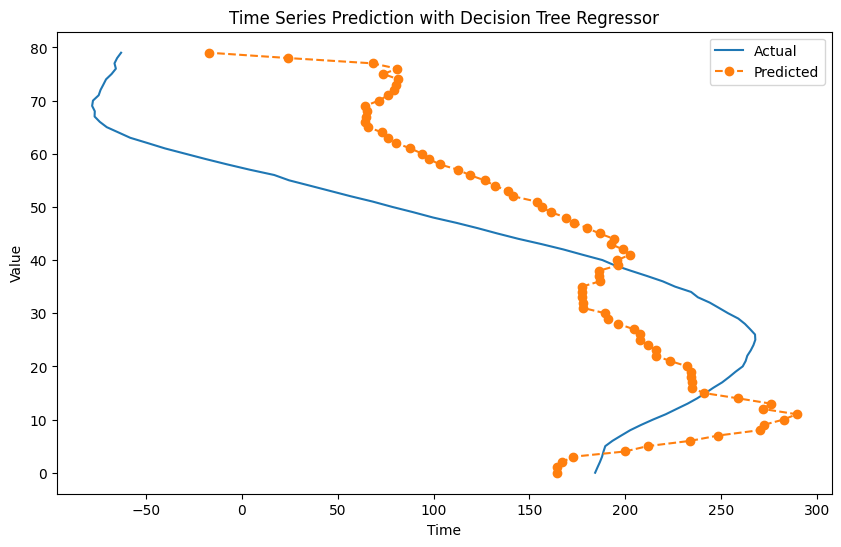

------- TESTING FOR 90 FRAMES -------
Root Mean Squared Error (RMSE): 79.03
Mean Absolute Error (MAE): 47.11
R-squared (R2): 0.73


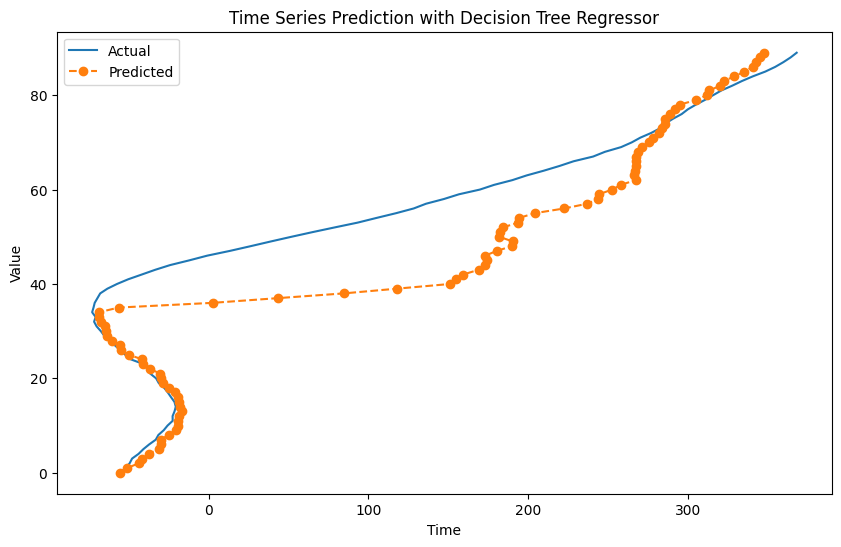

------- TESTING FOR 100 FRAMES -------
Root Mean Squared Error (RMSE): 51.31
Mean Absolute Error (MAE): 25.44
R-squared (R2): 0.50


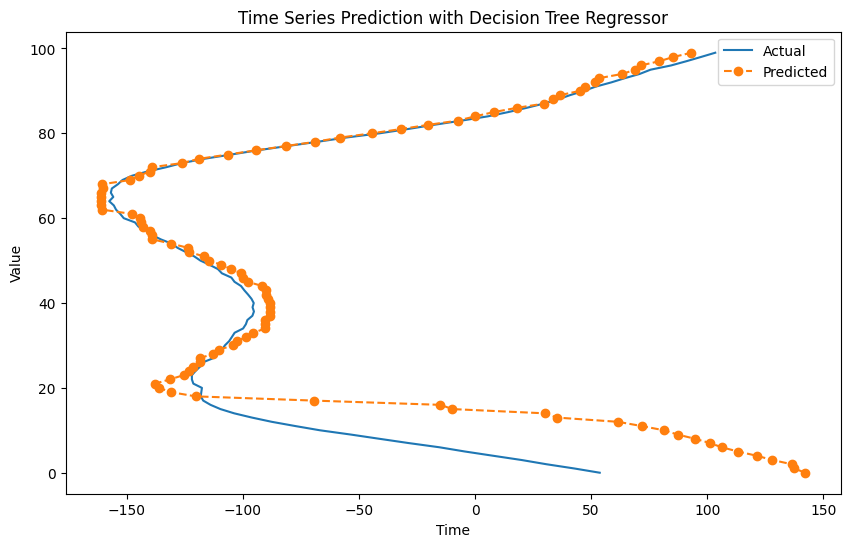

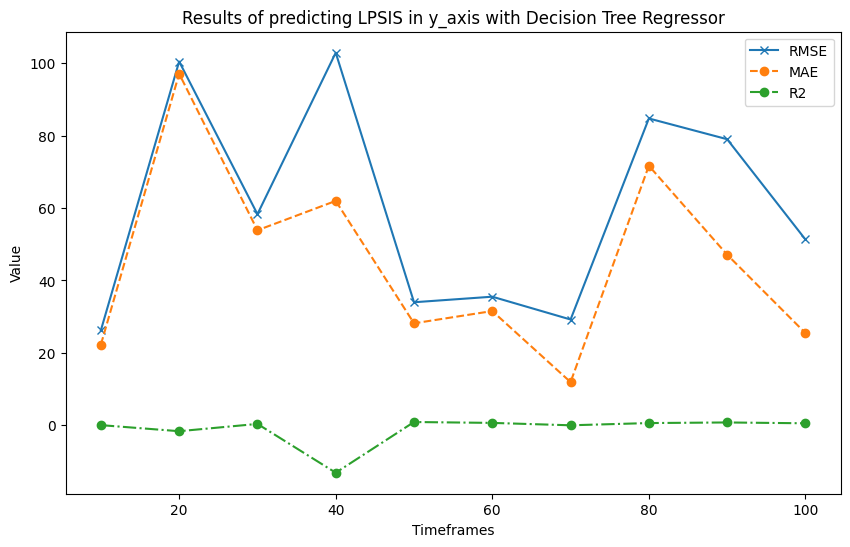

============== Z_AXIS ==============
------- TESTING FOR 10 FRAMES -------
Root Mean Squared Error (RMSE): 7.19
Mean Absolute Error (MAE): 6.96
R-squared (R2): -1.64


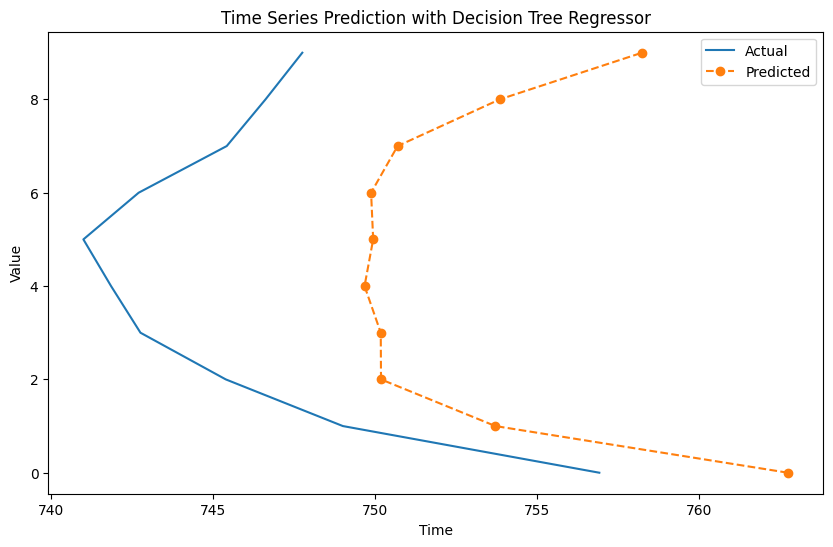

------- TESTING FOR 20 FRAMES -------
Root Mean Squared Error (RMSE): 3.81
Mean Absolute Error (MAE): 3.64
R-squared (R2): 1.00


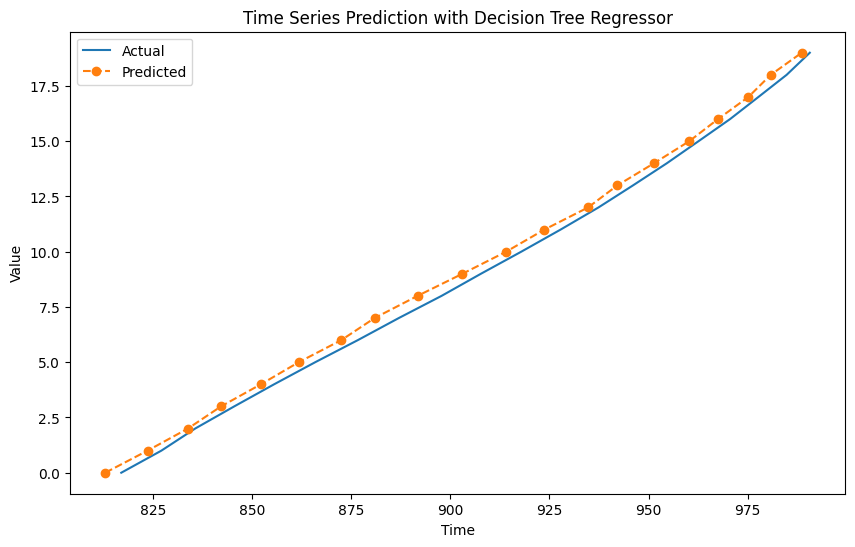

------- TESTING FOR 30 FRAMES -------
Root Mean Squared Error (RMSE): 3.43
Mean Absolute Error (MAE): 3.13
R-squared (R2): 0.99


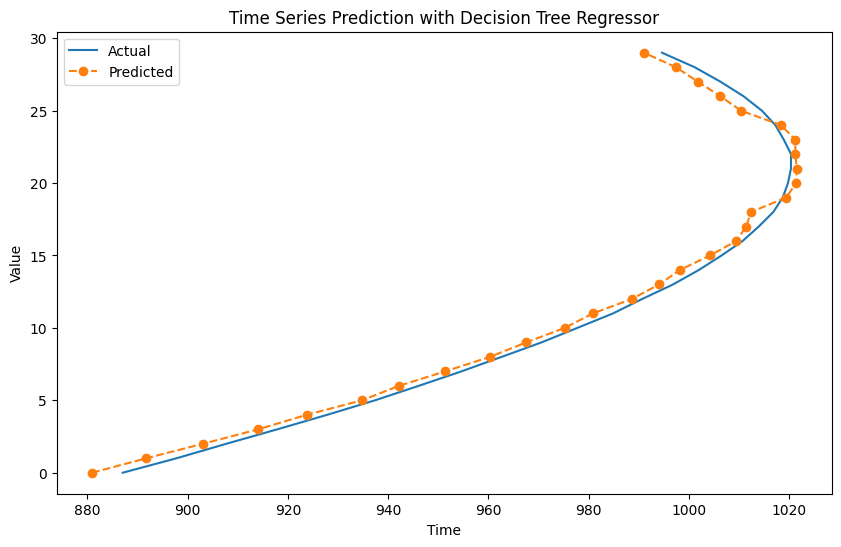

------- TESTING FOR 40 FRAMES -------
Root Mean Squared Error (RMSE): 4.64
Mean Absolute Error (MAE): 4.28
R-squared (R2): 1.00


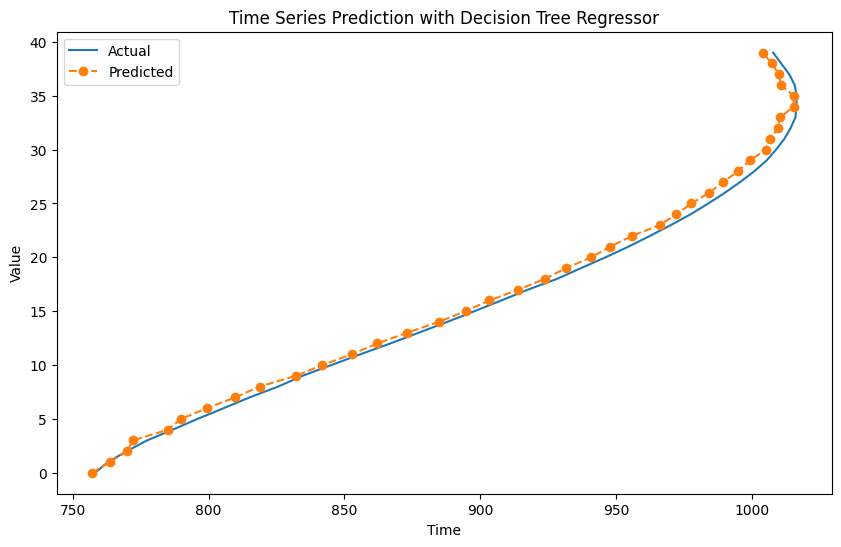

------- TESTING FOR 50 FRAMES -------
Root Mean Squared Error (RMSE): 4.06
Mean Absolute Error (MAE): 3.57
R-squared (R2): 1.00


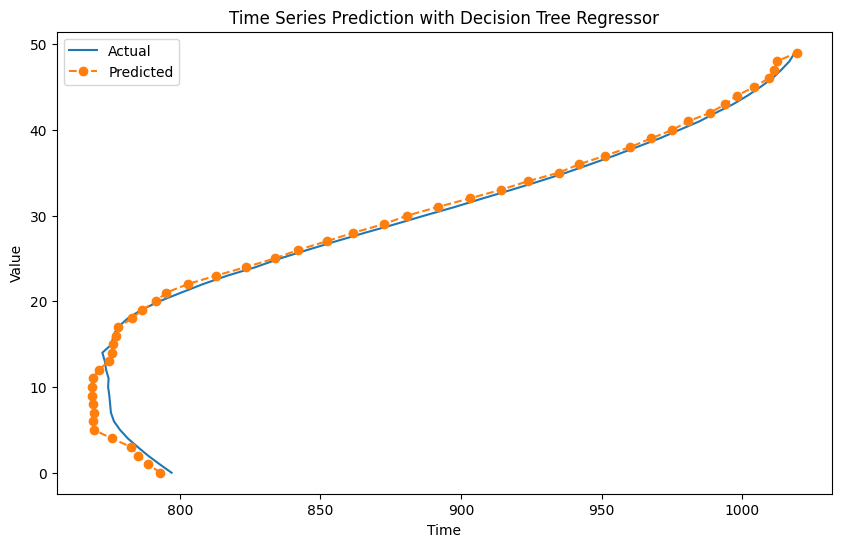

------- TESTING FOR 60 FRAMES -------
Root Mean Squared Error (RMSE): 2.52
Mean Absolute Error (MAE): 2.10
R-squared (R2): 1.00


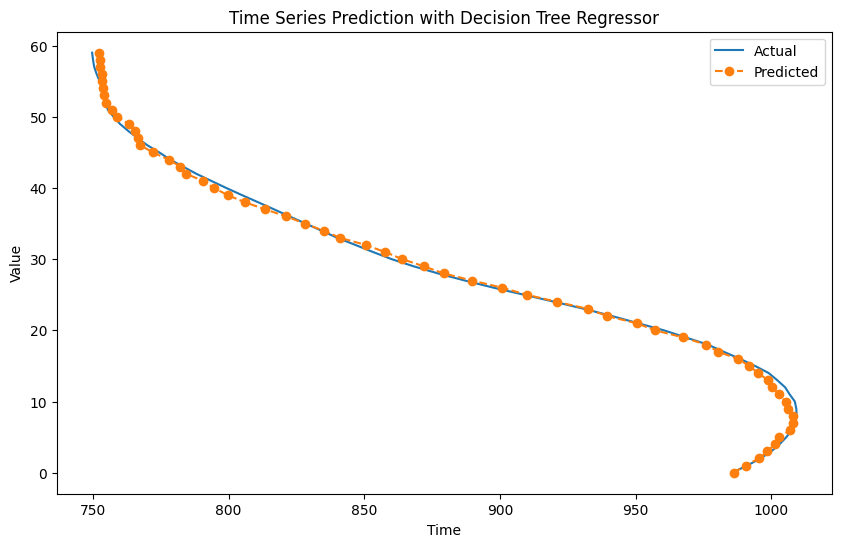

------- TESTING FOR 70 FRAMES -------
Root Mean Squared Error (RMSE): 3.90
Mean Absolute Error (MAE): 3.36
R-squared (R2): 1.00


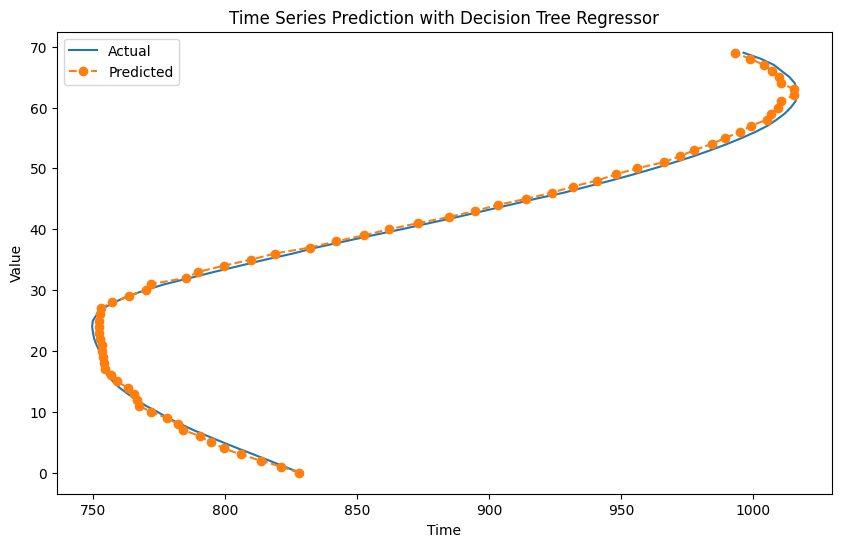

------- TESTING FOR 80 FRAMES -------
Root Mean Squared Error (RMSE): 2.78
Mean Absolute Error (MAE): 2.34
R-squared (R2): 1.00


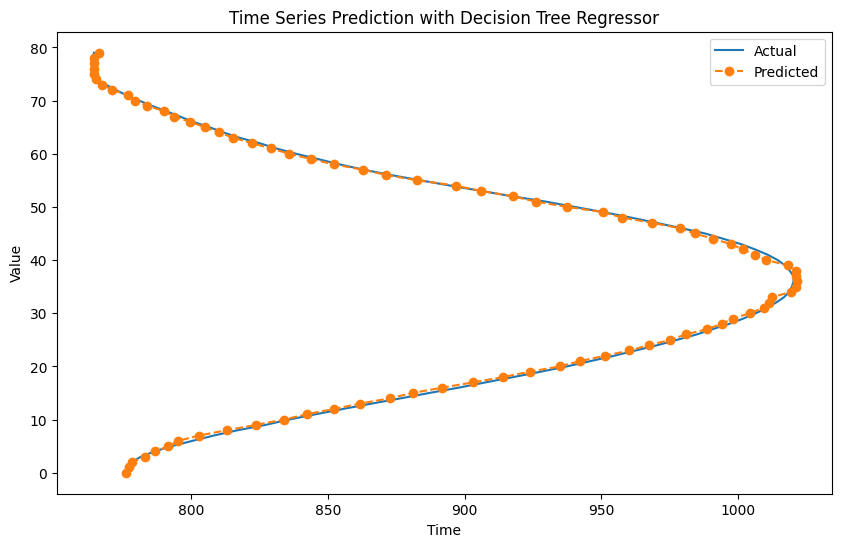

------- TESTING FOR 90 FRAMES -------
Root Mean Squared Error (RMSE): 3.53
Mean Absolute Error (MAE): 2.98
R-squared (R2): 1.00


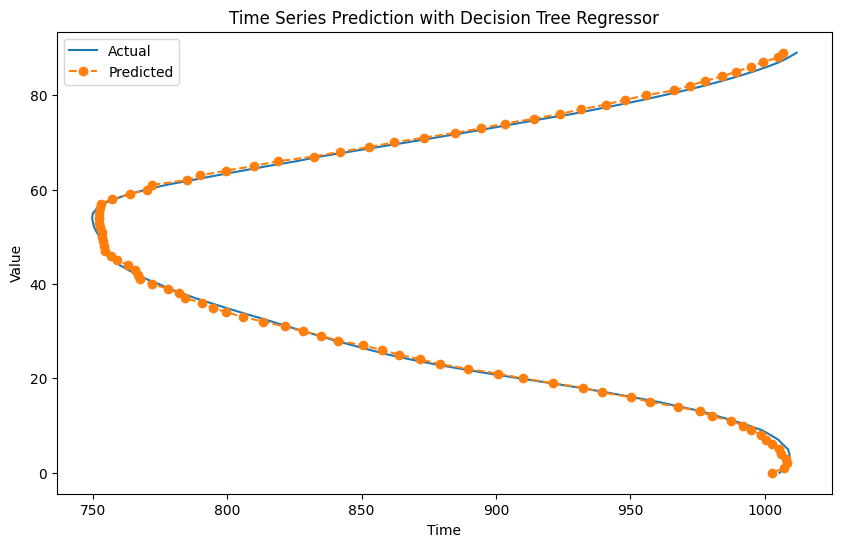

------- TESTING FOR 100 FRAMES -------
Root Mean Squared Error (RMSE): 3.65
Mean Absolute Error (MAE): 3.18
R-squared (R2): 1.00


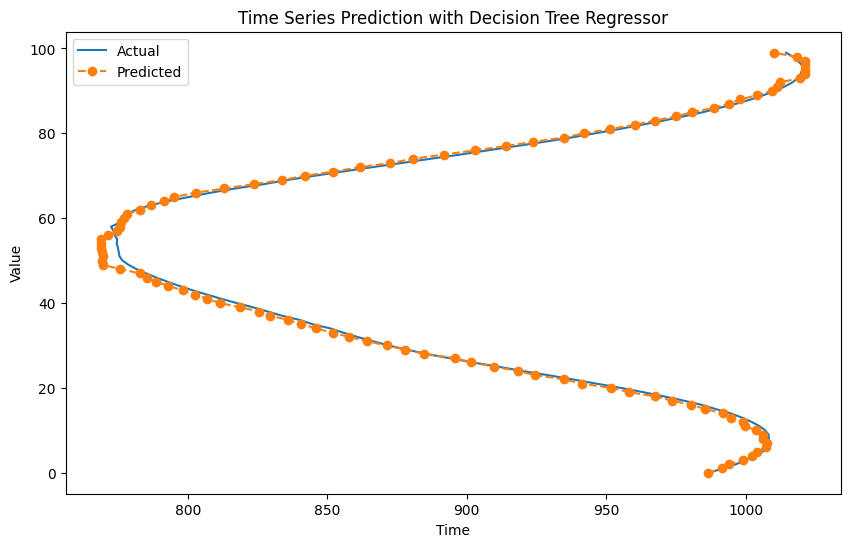

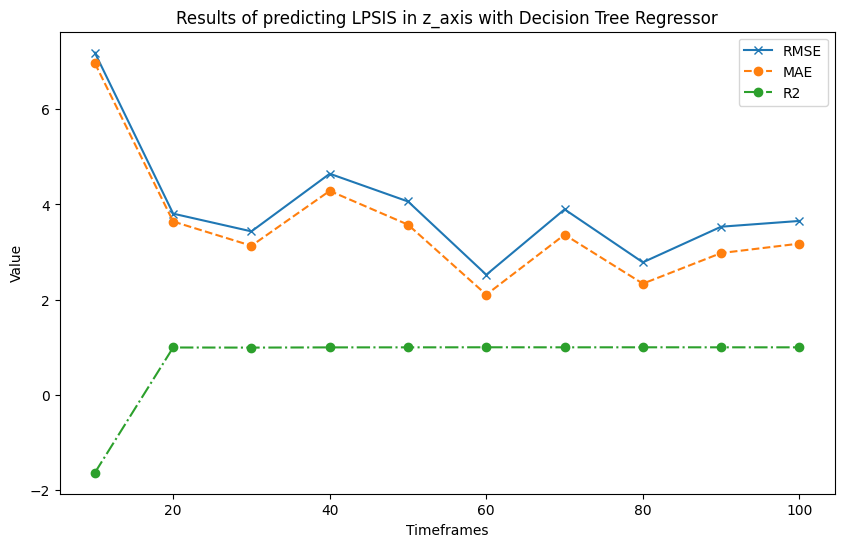

In [400]:
marker = "LPSIS"
axis = 0
axis_legend = {0:"x", 1:"y", 2:"z"}
for axis in axis_legend.keys():
    collated_RMSE = []
    collated_MAE = []
    collated_R2 = []
    print("============== " + axis_legend[axis].upper() + "_AXIS ==============")
    for timeframe in missing_timeframes_to_be_tested:
        print("------- TESTING FOR " + str(timeframe) + " FRAMES -------")
        X_train, X_test, y_train,  y_test = train_test_split(train_data, test_data, marker, sequence_of_markers, timeframe)
        
        # Create and train the decision tree regressor
        forest = RandomForestRegressor(random_state= 2023)
        forest.fit(X_train, y_train[axis])

        # Make predictions on the test data
        y_pred = forest.predict(X_test)

        # Calculate various regression metrics
        mse = mean_squared_error(inv_minmax_znorm(y_test[axis], minmax_scaling, "x", minmax=True), inv_minmax_znorm(y_pred, minmax_scaling, "x", minmax=True))
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(inv_minmax_znorm(y_test[axis], minmax_scaling, "x", minmax=True), inv_minmax_znorm(y_pred, minmax_scaling, "x", minmax=True))
        r2 = r2_score(inv_minmax_znorm(y_test[axis], minmax_scaling, "x", minmax=True), inv_minmax_znorm(y_pred, minmax_scaling, "x", minmax=True))

        # collated results
        collated_RMSE.append(rmse)
        collated_MAE.append(mae)
        collated_R2.append(r2)

        # same units as the target variable
        # RMSE = (MSE)^1/2
        print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

        # MAE measures the average absolute difference between predicted values and actual 
        # MAE = (1/n) * Σ|y_true - y_pred|
        print(f"Mean Absolute Error (MAE): {mae:.2f}")

        # a statistical metric used to measure the goodness of fit of a regression model
        print(f"R-squared (R2): {r2:.2f}")


        # Plot the actual vs. predicted time series
        plt.figure(figsize=(10, 6))
        plt.plot(inv_minmax_znorm(y_test[axis], minmax_scaling, "x", minmax=True), [i for i in range(y_test.shape[1])], label="Actual")
        plt.plot(inv_minmax_znorm(y_pred, minmax_scaling, "x", minmax=True), [i for i in range(y_test.shape[1])], label="Predicted", linestyle='--', marker='o')
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.legend()
        plt.title("Time Series Prediction with Decision Tree Regressor")
        plt.show()


    # Plot the results versus the missing timeframes tested
    plt.figure(figsize=(10, 6))
    plt.plot(missing_timeframes_to_be_tested, collated_RMSE, label="RMSE", marker='x')
    plt.plot(missing_timeframes_to_be_tested, collated_MAE, label="MAE", linestyle='--', marker='o')
    plt.plot(missing_timeframes_to_be_tested, collated_R2, label="R2", linestyle='-.', marker='o')
    plt.xlabel("Timeframes")
    plt.ylabel("Value")
    plt.legend()
    plt.title("Results of predicting " +  marker + " in "+ axis_legend[axis] + "_axis with Decision Tree Regressor")
    plt.show()

Root Mean Squared Error (RMSE): 8.21
Mean Absolute Error (MAE): 5.44
R-squared (R2): 1.00


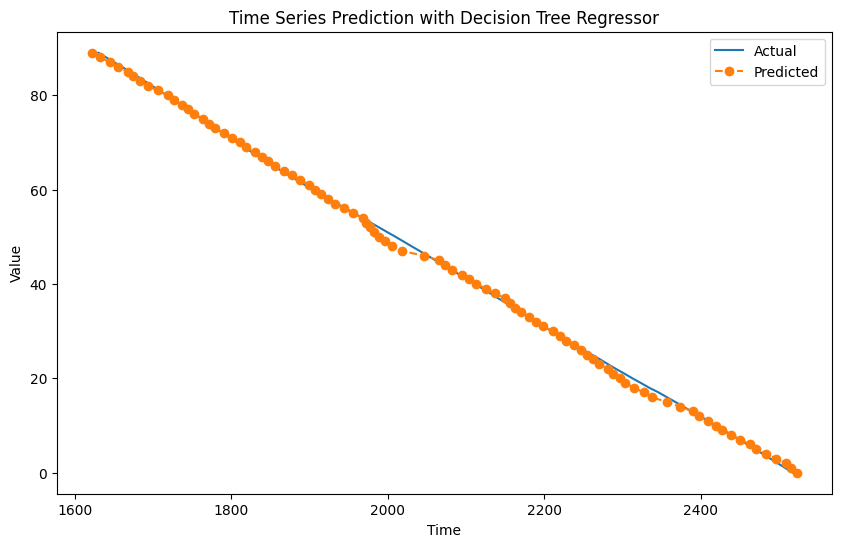

In [395]:
timeframe_to_test = 90
X_train, X_test, y_train,  y_test = train_test_split(train_data, test_data, "LPSIS", sequence_of_markers, timeframe_to_test)

# Create and train the decision tree regressor
forest = RandomForestRegressor(random_state= 2023)
forest.fit(X_train, y_train[0])

# Make predictions on the test data
y_pred = forest.predict(X_test)

# Calculate various regression metrics
mse = mean_squared_error(inv_minmax_znorm(y_test[0], minmax_scaling, "x", minmax=True), inv_minmax_znorm(y_pred, minmax_scaling, "x", minmax=True))
rmse = np.sqrt(mse)
mae = mean_absolute_error(inv_minmax_znorm(y_test[0], minmax_scaling, "x", minmax=True), inv_minmax_znorm(y_pred, minmax_scaling, "x", minmax=True))
r2 = r2_score(inv_minmax_znorm(y_test[0], minmax_scaling, "x", minmax=True), inv_minmax_znorm(y_pred, minmax_scaling, "x", minmax=True))
# adjusted_r_squared = 1 - (1 - r2) * (len(y_test[0]) - 1) / (len(y_test[0]) - X_train.shape[1] - 1)

# # MSE measures the average squared difference between predicted values and actual target values. 
# # penalizes larger errors more than smaller ones.
# # MSE = (1/n) * Σ(y_true - y_pred)^2
# print(f"Mean Squared Error (MSE): {mse:.2f}")

# same units as the target variable
# RMSE = (MSE)^1/2
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# MAE measures the average absolute difference between predicted values and actual 
# MAE = (1/n) * Σ|y_true - y_pred|
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# a statistical metric used to measure the goodness of fit of a regression model
print(f"R-squared (R2): {r2:.2f}")

# # Adjusted R-squared takes into account the number of predictors and penalizes the inclusion of irrelevant variables.
# print(f"Adjusted R-squared: {adjusted_r_squared:.2f}")

# Plot the actual vs. predicted time series
plt.figure(figsize=(10, 6))
plt.plot(inv_minmax_znorm(y_test[0], minmax_scaling, "x", minmax=True), [i for i in range(y_test.shape[1])], label="Actual")
plt.plot(inv_minmax_znorm(y_pred, minmax_scaling, "x", minmax=True), [i for i in range(y_test.shape[1])], label="Predicted", linestyle='--', marker='o')
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.title("Time Series Prediction with Decision Tree Regressor")
plt.show()


### if want to split grouping into left and right

In [27]:
# markers_grouping = markers_dict = {
#     'R_head':[
#         'RHEAD',
#         'RTEMP'],

#     'L_head':[
#         'LHEAD',
#         'LTEMP'],

#     'R_shoulder':[
#         'RACR'],

#     'L_shoulder':[
#         'LACR'],

#     'front_torso':[
#         'STER',
#         'XPRO'],

#     'back_torso':[    
#         'C7',
#         'T4',
#         'T8',
#         'T10'],
    

#     'R_pelvis':[
#         'RPSIS',
#         'RICR',
#         'RASIS'],

#     'L_pelvis':[
#         'LPSIS',
#         'LASIS',
#         'LICR'],

#     'R_arm':[    
#         'RHME',
#         'RHLE',
#         'RUA1',
#         'RUA2',
#         'RUA3',
#         'RUA4'],
    
#     'L_arm':[
#         'LHME',
#         'LHLE',
#         'LUA1',
#         'LUA2',
#         'LUA3',
#         'LUA4'],

#     'R_wrist':[
#         'RRSP',
#         'RUSP',
#         'RFA3',
#         'RFA2',
#         'RFA1'],

#     'L_wrist':[
#         'LFA1',
#         'LFA2',
#         'LFA3',
#         'LRSP',
#         'LUSP'],

#     'R_hand':[
#         'RCAP',
#         'RHMC1',
#         'RHMC2',
#         'RHMC3'],
    
#     'L_hand':[
#         'LCAP',
#         'LHMC1',
#         'LHMC2',
#         'LHMC3'],

#     'R_fingers':[
#         'RTHUMB',
#         'RMIDDLE'],
    
#     'L_fingers':[
#         'LTHUMB',
#         'LMIDDLE'],

#     'R_thigh':[
#         'RFLE',
#         'RFME',
#         'RTH1',
#         'RTH2',
#         'RTH3',
#         'RTH4'],
    
#     'L_thigh':[
#         'LFLE',
#         'LFME',
#         'LTH1',
#         'LTH2',
#         'LTH3',
#         'LTH4'],

#     'R_calf':[
#         'RSK1',
#         'RSK2',
#         'RSK3',
#         'RSK4',
#         'RFAL',
#         'RTAM'],
        
#     'L_calf':[
#         'LSK1',
#         'LSK2',
#         'LSK3',
#         'LSK4',
#         'LFAL',
#         'LTAM'],

#     'R_foot':[
#         'RFCC',
#         'RFMT5',
#         'RFMT2',
#         'RFMT1'],

#     'L_foot':[
#         'LFCC',
#         'LFMT5',
#         'LFMT2',
#         'LFMT1']
#     }
